In [1]:
from duckduckgo_search import ddg_images
from fastcore.all import *
from fastai.vision.widgets import *
from fastdownload import download_url
from fastai.vision.all import *
from time import sleep
import pandas as pd
import wandb
import params
import utils

def search_images(term, max_images=20):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [2]:
%%time
# searches = ['Panthera onca','Panthera pardus','Panthera leo','Panthera tigris','Panthera unica','Acinonyx']
searches = ['Tiger', 'Leopard', 'Jaguar', 'Cheetah', 'Snow Leopard', 'Black Panther', 'Lion']
path = Path('Dataset/Big Cats')
# _download_images(path, searches)

CPU times: user 35 µs, sys: 17 µs, total: 52 µs
Wall time: 55.6 µs


In [3]:
data = utils._prepare_data(path, searches)

In [4]:
data

,Image,Label
0,36b6dbaa-3278-4170-a4fd-f7b88ef681fd.jpg,Tiger
1,1f1bcd84-4265-466a-aaf8-134ed1475adc.jpg,Tiger
2,cc29143e-eca5-4189-b96b-cde6e5170afa.jpg,Tiger
3,ad5b4bde-1da1-4e5a-aee2-bdc61b5c29f5.jpg,Tiger
4,f40ab478-1784-48db-b637-15f3d116afdf.jpg,Tiger
...,...,...
36,1f6bd088-a160-457e-a20b-4cf9b6672d89.jpg,Lion
37,fd956b20-d49a-46f5-baa1-3dcc728e63e2.jpg,Lion
38,529b1f58-7b5b-4aa0-9271-6c76125837d1.jpg,Lion
39,12b92325-2911-4087-a4ed-18bbb3b95c76.jpg,Lion


In [5]:
run = wandb.init(project=params.WANDB_PROJECT, entity=None, job_type="upload_bigcats_clean")

wandb: Currently logged in as: gsparsh. Use `wandb login --relogin` to force relogin


In [6]:
artifact = wandb.Artifact(params.CLEAN_DATA_AT, type="clean_data")

In [7]:
artifact.add_dir(path, name='bcc_images')

wandb: Adding directory to artifact (./Dataset/Big Cats)... Done. 0.2s


In [8]:
image_files = get_image_files(path)

In [9]:
image_files

(#292) [Path('Dataset/Big Cats/Black Panther/db0c615f-085d-48b6-9aee-d63f0630f7cd.jpg'),Path('Dataset/Big Cats/Black Panther/441f7da5-4c43-4ae6-9680-7b2659c9b32d.jpg'),Path('Dataset/Big Cats/Black Panther/7e1292b7-44ce-432c-a659-90dc51ab80e9.jpg'),Path('Dataset/Big Cats/Black Panther/90f3a667-cbf9-4fb8-820e-9207007d34ac.jpg'),Path('Dataset/Big Cats/Black Panther/9ad5e25a-2bb7-4202-84cd-041567f215d4.jpg'),Path('Dataset/Big Cats/Black Panther/3b21f0c5-d131-4bfb-b792-f512de4ee8d6.jpg'),Path('Dataset/Big Cats/Black Panther/dc7e96d6-1cb2-4c3c-9c76-732578f718ea.jpg'),Path('Dataset/Big Cats/Black Panther/452df5d8-37c7-4cc8-b303-b4f58923f8eb.jpg'),Path('Dataset/Big Cats/Black Panther/e8534798-5b49-4a29-bc1c-5b4e8c12ec24.jpeg'),Path('Dataset/Big Cats/Black Panther/6dffb2f7-2c3c-4bb0-974f-d14a449384e0.jpg')...]

In [10]:
table = utils._create_table(image_files, data, dataset_name='bigcats_clean')

In [11]:
artifact.add(table, "eda_table")

ArtifactManifestEntry(path='eda_table.table.json', digest='RyOOg/SvnhHqkrnZ/DtNKw==', ref=None, birth_artifact_id=None, size=79354, extra={}, local_path='/root/.local/share/wandb/artifacts/staging/tmpxziuu993')

In [12]:
run.log_artifact(artifact)
run.finish()

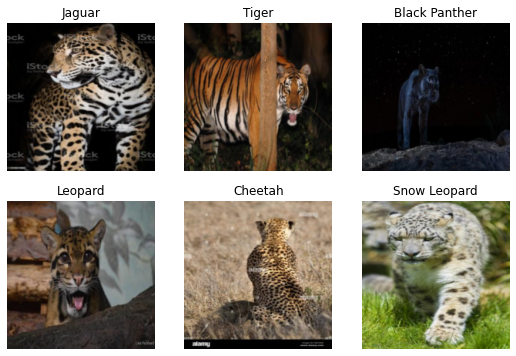

In [134]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [135]:
learn = vision_learner(dls, resnet18, metrics=error_rate)

In [136]:
cleaner = ImageClassifierCleaner(learn)

In [137]:
cleaner

In [133]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)